**Resouces:**

Explanation on the resnet architecture: input_size/output_size/kernel/stride at each layer:
https://medium.com/@14prakash/understanding-and-implementing-architectures-of-resnet-and-resnext-for-state-of-the-art-image-cf51669e1624

Resnet50 Architecture:
https://www.kaggle.com/keras/resnet50

Simple way of unpacking resnetX for stripping out FC layers and such:
https://discuss.pytorch.org/t/resnet-pretrained-model-with-last-fc-layer-stripped-does-not-work/17951

Reason as to why we want to resize each image and their labels to 224 x 224:
https://stackoverflow.com/questions/43922308/what-input-image-size-is-correct-for-the-version-of-resnet-v2-in-tensorflow-slim

How to modify the FC layer of resnet:
https://discuss.pytorch.org/t/how-to-modify-the-final-fc-layer-based-on-the-torch-model/766/3

**Data preprocessing requirement:**

In order to define the heatmap loss as torch.nn.functional.cross_entropy(input, target, weight=None, size_average=True, ignore_index=-100, reduce=True):

We need to have the target/label take on the form of (N, J, H, W)

Each j in J represents a joint

**Important:** The image is of size (N, 3, H, W)

In [39]:
# Loading our own functions
import math
import torch
import torch.nn as nn
import numpy as np
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, sampler
from libs.data_utils import HandDataset, ToTensor, Scale
from libs.layer_utils import flatten, random_weight, zero_weight
from torchvision import transforms, utils
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

def show_joints(image, pos_2d, pos_3d):
    fig = plt.figure(figsize=plt.figaspect(2.))
    ax = fig.add_subplot(2,1,1)
    height, width, depth = image.shape
    ax.imshow(image)
    ax.scatter(pos_2d[:,0], pos_2d[:, 1], s=10, marker='.', c='r')
    ax = fig.add_subplot(2,1,2, projection="3d")
    ax.view_init(-90,-90)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.scatter(pos_3d[:,0], pos_3d[:,1], pos_3d[:,2], s=30)
    plt.show()

# define heatmap guassian size
g_heatmap_size = 9

def makeHeatMapOneHot(pos2d_list, batch_size, num_joints, image_size):
    # heatmap 0 based, should we have a very small number instead of 0?
    one_hot = torch.zeros(batch_size, num_joints, image_size, image_size) # size (N, 21, 224, 224)
    heatmap = torch.zeros(batch_size, num_joints, image_size + g_heatmap_size - 1, image_size + g_heatmap_size - 1) 
    # size (N, 21, 224 + 8, 224 + 8)
    # Hao: Took me a while, but eventually figured out a way to do 4D indexing
    b_idx = torch.from_numpy(np.repeat(np.arange(batch_size), num_joints)).long()
    j_idx = torch.from_numpy( np.array(list(np.arange(num_joints))*batch_size) ).long()
    h_idx = pos2d_list[:, :, 1].view(-1).long()
    w_idx = pos2d_list[:, :, 0].view(-1).long()
    
    one_hot[b_idx, j_idx, h_idx, w_idx] = 1.0
    
    padding = int((g_heatmap_size - 1)/2)
    
    # still need some loops, but at least we only need a double loop, yeahhh, I guess
    for dh in range(-4, 5):
        for dw in range(-4, 5):
            cur_h_idx = h_idx + dh + padding
            cur_w_idx = w_idx + dw + padding
            cur_h_idx = cur_h_idx.long()
            cur_w_idx = cur_w_idx.long()
            heatmap[b_idx, j_idx, cur_h_idx, cur_w_idx] = math.exp(-1.0 * (dw**2 + dh**2))
            #loc_map_x[b_idx, j_idx, cur_h_idx, cur_w_idx] = pos3d_list[:, :, 0].view(-1).float()
            #loc_map_y[b_idx, j_idx, cur_h_idx, cur_w_idx] = pos3d_list[:, :, 1].view(-1).float()
            #loc_map_z[b_idx, j_idx, cur_h_idx, cur_w_idx] = pos3d_list[:, :, 2].view(-1).float()
    return heatmap[:, :, padding:-padding, padding:-padding], one_hot
    
def makeMaps(pos2d_list, pos3d_list, batch_size, num_joints, image_size):
    
    # this is a quadruple loop for now, can we possibly verctorize it?
    # Change: make locmaps take on constant value through out spatial dimension
    # for example, loc_map_x(b=0, j=0, h=:, w=:) should take on the x value of joint 0 in sample 0
    loc_map_x = torch.zeros(batch_size, num_joints, image_size, image_size)
    loc_map_y = torch.zeros(batch_size, num_joints, image_size, image_size)
    loc_map_z = torch.zeros(batch_size, num_joints, image_size, image_size)
    
    loc_map_x += pos3d_list[:, :, 0].view(batch_size, num_joints, 1, 1).float()
    loc_map_y += pos3d_list[:, :, 1].view(batch_size, num_joints, 1, 1).float()
    loc_map_z += pos3d_list[:, :, 2].view(batch_size, num_joints, 1, 1).float()
    
    heatmap, one_hot = makeHeatMapOneHot(pos2d_list, batch_size, num_joints, image_size)       

    #loc_map = torch.cat((loc_map_x[:, :, padding:-padding, padding:-padding], loc_map_y[:, :, padding:-padding, padding:-padding], loc_map_z[:, :, padding:-padding, padding:-padding]), dim=1)
    loc_map = torch.cat((loc_map_x, loc_map_y, loc_map_z), dim=1)
    return loc_map, heatmap, one_hot

def makeMapsNaive(pos2d_list, pos3d_list, batch_size, num_joints, image_size):
    
    # heatmap 0 based, should we have a very small number instead of 0
    heatmap = torch.zeros(batch_size, num_joints, image_size, image_size) # size (N, 21, 224, 224)
    one_hot = torch.zeros(batch_size, num_joints, image_size, image_size) # size (N, 21, 224, 224)
    # this is a quadruple loop for now, can we possibly verctorize it?
    loc_map_x = torch.zeros(batch_size, num_joints, image_size, image_size)
    loc_map_y = torch.zeros(batch_size, num_joints, image_size, image_size)
    loc_map_z = torch.zeros(batch_size, num_joints, image_size, image_size)
    
    loc_map_x = loc_map_x + pos3d_list[:, :, 0].view(batch_size, num_joints, 1, 1).float()
    loc_map_y = loc_map_y + pos3d_list[:, :, 1].view(batch_size, num_joints, 1, 1).float()
    loc_map_z = loc_map_z + pos3d_list[:, :, 2].view(batch_size, num_joints, 1, 1).float()
    
    for b in range(0, batch_size):
        for i in range(0, num_joints):
            one_hot[b, i, int(pos2d_list[b, i, 1]), int(pos2d_list[b, i, 0])] = 1.0
            
            for delta_x in range(-4, 5):
                x = pos2d_list[b, i, 0] + delta_x
                if x > 0 and x < image_size:
                    for delta_y in range(-4, 5):
                        y = pos2d_list[b, i, 1] + delta_y
                        if y > 0 and y < image_size:
                            # guassian-like heatmap
                            heatmap[b, i, int(y), int(x)] = math.exp(-1.0 * (delta_x**2 + delta_y**2))
                            #1.0 - (delta_x**2 + delta_y**2) / 32
                            # all points around the joint take on the 3D position of the joint for our location map GT
                            #loc_map_x[b, i, int(y), int(x)] = pos3d_list[b, i, 0].float()
                            #loc_map_y[b, i, int(y), int(x)] = pos3d_list[b, i, 1].float()
                            #loc_map_z[b, i, int(y), int(x)] = pos3d_list[b, i, 2].float()

    loc_map = torch.cat((loc_map_x, loc_map_y, loc_map_z), dim=1)
    return loc_map, heatmap, one_hot

# define some constants
num_joints = 21
image_size = 224
dtype = torch.float32

transform = transforms.Compose([
    Scale(image_size, image_size),
    ToTensor(),
])

**Load data:**

In [40]:
import time
batch_size = 2

hand_train = HandDataset('toy_dataset.csv', transform=transform, train=True)
N = 100 #len(hand_train)
loader_train = DataLoader(hand_train, batch_size=batch_size,
            sampler=sampler.SubsetRandomSampler(range(int(N*0.8))))

hand_val = HandDataset('toy_dataset.csv', transform=transform, train=True)
loader_val = DataLoader(hand_val, batch_size=batch_size,
            sampler=sampler.SubsetRandomSampler(range(int(N*0.8), int(N*0.9))))

hand_test = HandDataset('toy_dataset.csv', transform=transform, train=False)
loader_test = DataLoader(hand_test, batch_size=batch_size,
                         sampler=sampler.SubsetRandomSampler(range(int(N*0.9),N)))

for i_batch, batch in enumerate(loader_train):
    print(i_batch, batch['image'].size())
    print(i_batch, batch['pos_2d'].size())
    print(i_batch, batch['pos_3d'].size())
    image = batch['image']
    pos2d_list = batch['pos_2d'] # size (N, 21, 2)
    pos3d_list = batch['pos_3d'] # size (N, 21, 3)
    print(pos3d_list)
    
    start_time = time.time()
    loc_map, heatmap, one_hot = makeMaps(pos2d_list, pos3d_list, batch_size, num_joints, image_size)
    print("vectorized: --- %s seconds ---" % (time.time() - start_time))
    
    start_time = time.time()
    loc_map_n, heatmap_n, one_hot_n = makeMapsNaive(pos2d_list, pos3d_list, batch_size, num_joints, image_size)
    print("naive: --- %s seconds ---" % (time.time() - start_time))
    
    print("Check the difference between vectorized impl and naive impl:")
    print("Error:", torch.sum(loc_map - loc_map_n))
    print("Error:", torch.sum(heatmap - heatmap_n))
    print("Error:", torch.sum(one_hot - one_hot_n))
    
    #print(heatmap.shape)
    #print(loc_map[0, 0])
    #for j in range(image_size):
    #    print(heatmap[0, 0, j])
    break

0 torch.Size([2, 3, 224, 224])
0 torch.Size([2, 21, 2])
0 torch.Size([2, 21, 3])
tensor([[[  43.6957,   21.5230,  367.3360],
         [  35.5937,   44.9111,  400.2308],
         [  49.0574,   14.7722,  345.8399],
         [  53.0545,   14.5642,  329.9653],
         [  12.7375,   16.7387,  360.9321],
         [  14.5086,   44.0014,  398.1713],
         [  13.7260,    8.5131,  334.9737],
         [  15.5705,    8.4731,  317.0622],
         [ -38.8389,   36.3590,  379.8563],
         [ -25.6596,   54.1008,  405.5369],
         [ -44.0881,   31.2973,  362.5918],
         [ -46.6217,   31.1303,  346.2716],
         [ -12.4862,   21.3143,  367.6562],
         [  -6.8722,   46.8988,  401.5210],
         [ -13.6837,   12.4969,  342.6478],
         [ -12.9735,   11.5485,  324.7835],
         [  59.7601,   61.4570,  443.8006],
         [  24.4186,   76.1328,  472.4966],
         [  81.2246,   52.8083,  420.7386],
         [  99.9469,   44.7593,  411.3793],
         [   9.5811,   55.1454,  419.52

**Build the model:**

In [57]:
def computeLoss(heatmap, one_hot, loc_map, h_pred, l_pred, batch_size, num_joints, image_size):
    # TODO: how to combine l_loss and h_loss is about hyper-parameter tuning
    
    hmap_pred = nn.functional.softmax(h_pred.view(batch_size, num_joints, -1), dim=2)
    h_loss = torch.sum(hmap_pred * one_hot.view(batch_size, num_joints, -1), dim=2)
    h_loss = torch.sum(-1.0 * h_loss.log()) / (batch_size * num_joints)
    #torch.sum(torch.pow(nn.functional.softmax(y_pred[:, 63:, :, :].view(batch_size, 21, -1), dim=2) - heatmap.view(batch_size, 21, -1), 2)) / batch_size
    
    '''
    Hao: construct a combined heatmap of both the ground truth and our predicted heatmap
    since the fact that joints exist at a certain point should offer clue to what its 3D position might be
    '''
    p2d_y, p2d_x = np.unravel_index(torch.argmax(hmap_pred.view(batch_size * num_joints, -1), dim=1).data.numpy(), (image_size, image_size))
    p2d_y = p2d_y.reshape((batch_size, num_joints))
    p2d_x = p2d_x.reshape((batch_size, num_joints))
    p2d = np.stack((p2d_x, p2d_y), axis=-1)
    
    hp, _ = makeHeatMapOneHot(torch.from_numpy(p2d), batch_size, num_joints, image_size)
    
    # total heatmap
    t_heatmap = hp + heatmap
    
    l_loss = 0.005 * torch.sum(torch.pow(t_heatmap.repeat(1, 3, 1, 1) * (l_pred - loc_map), 2)) / (batch_size * num_joints * 9**2 * 3)
    loss = l_loss + h_loss
    return loss

    
# Use renet 34 for speed, later may use resnet50 as our base NN stucture for joints detection
resnet34 = models.resnet34(pretrained=True)
#resnet34.cuda()
for param in resnet34.parameters():
    # don't change/update the pretrained model parameters, only change the final fc layer
    param.requires_grad = False

# Upsample using transpose convolution and unpooling
# output_padding = 1 is intended to recover proper size
transConv1 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
transConv2 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
transConv3 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
# Note: the following layer should have been maxunpooling, kernel 3 x 3, stride 2
# torch.nn.MaxUnpool2d() requires modification of the torchvision resnetXX modules
# to have the maxpooling layer return indices of max values, try ConvTranspose2d() instead
# If this doesn't work, have to and implement custom version of resnet
transConv4 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
transConv5 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=7, stride=2, padding=3, output_padding=1) # (224 x 224)

# finally, the joint prediction Convolutional Layer, filter size 3 x 3, 21 filters
# VNect's 2D heatmap is generated from res4d, and location maps from res5a, we try something simpler
jointPrediction = nn.Conv2d(in_channels=64, out_channels=21, kernel_size=3, stride=1, padding=1)

# layers to generate the location maps
conv6 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
conv7 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
locationPrediction = nn.Conv2d(in_channels=128, out_channels=63, kernel_size=3, stride=1, padding=1)

# stick a bunch of ReLu non-linearity in the upsampling pipeline
model = nn.Sequential(
    *list(resnet34.children())[:-2],
    transConv1,
    nn.ReLU(),
    transConv2,
    nn.ReLU(),
    transConv3,
    nn.ReLU(),
    transConv4,
    nn.ReLU(),
    transConv5,
    nn.ReLU(),
)

modelHeatmap = nn.Sequential(
    jointPrediction
)

modelLocmap = nn.Sequential(
    conv6,
    nn.ReLU(),
    conv7,
    nn.ReLU(),
    locationPrediction
)

# use a toy model to make sure that the location map implementations are correct
#model = nn.Sequential(
#    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
#    nn.Conv2d(in_channels=64, out_channels=63, kernel_size=3, stride=1, padding=1)
#)

# model.cuda()
# .cuda() makes model run on GPU

**Training the model and evaluate on eval dataset:**

In [58]:
# optimizer using adam
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, list(model.parameters()) + list(modelHeatmap.parameters()) + list(modelLocmap.parameters()) ), lr = 0.001)
losses = []

for epoch in range(50):
    print("Epoch: {}".format(epoch))
    for idx, batch in enumerate(loader_train):
        # make all the ground truth tensors needed for loss computation
        image = batch['image'].float()
        pos2d_list = batch['pos_2d'] # size (N, 21, 2)
        pos3d_list = batch['pos_3d'] # size (N, 21, 3)
        loc_map, heatmap, one_hot = makeMaps(pos2d_list, pos3d_list, batch_size, num_joints, image_size)
        # y_pred is of size 224 x 224 x 84, and let's say the filter dimension is layed out in the following way:
        # dimension 0-20: j1_x, j2_x, j3_x,...j21_x, dimension 21-41: j1_y, j2_y, j3_y, ... 
        # Above is for conveniently using broadcasting with heatmap element-wise product
        # y_pred is the predicted location maps + 2Dheatmap for all 21 joints
        y_pred = model(image)
        h_pred = modelHeatmap(y_pred)
        l_pred = modelLocmap(y_pred)
        #print("output shape: {}".format(y_pred.shape))
        # use heatmap loss defined in VNect
        loss = computeLoss(heatmap, one_hot, loc_map, h_pred, l_pred, batch_size, num_joints, image_size)
        
        # print and store the loss curve
        print("Loss: {}".format(loss))
        losses.append(loss)
        
        loss.backward()
        optimizer.step()
        # Clears the gradients of all optimized torch.Tensor s
        optimizer.zero_grad()
        
print("======Training Done======")

Epoch: 0
Loss: 23.58706283569336
Loss: 28.683015823364258
Loss: 24.870569229125977
Loss: 31.974428176879883
Loss: 33.552215576171875
Loss: 34.30513000488281
Loss: 28.078041076660156
Loss: 32.77165985107422
Loss: 20.20549964904785
Loss: 22.824201583862305
Loss: 16.336627960205078
Loss: 18.92092514038086
Loss: 25.099567413330078
Loss: 14.005963325500488
Loss: 15.640792846679688
Loss: 16.99772071838379
Loss: 21.315608978271484
Loss: 16.22838592529297
Loss: 16.010135650634766
Loss: 12.143763542175293
Loss: 14.335731506347656
Loss: 13.902560234069824
Loss: 14.942930221557617
Loss: 13.289535522460938
Loss: 10.979069709777832
Loss: 11.036577224731445
Loss: 13.952009201049805
Loss: 10.73370361328125
Loss: 12.155899047851562
Loss: 12.146451950073242
Loss: 11.820002555847168
Loss: 11.914446830749512
Loss: 10.68202018737793
Loss: 10.786234855651855
Loss: 11.363460540771484
Loss: 10.936776161193848
Loss: 11.106504440307617
Loss: 10.355716705322266
Loss: 12.734519958496094
Loss: 10.53194522857666
E

Loss: 6.536722660064697
Loss: 7.1702880859375
Loss: 7.020963668823242
Loss: 6.84515905380249
Loss: 8.161251068115234
Loss: 6.517378807067871
Loss: 7.278753280639648
Loss: 7.889926910400391
Loss: 8.590877532958984
Loss: 7.908637046813965
Loss: 7.467390060424805
Loss: 7.9003987312316895
Loss: 8.388233184814453
Loss: 7.722708225250244
Loss: 6.2952446937561035
Loss: 8.014497756958008
Loss: 7.398698806762695
Loss: 7.292352676391602
Loss: 7.450489044189453
Loss: 9.727704048156738
Loss: 7.803014755249023
Loss: 7.033422946929932
Epoch: 9
Loss: 7.090897083282471
Loss: 6.312967777252197
Loss: 6.776149272918701
Loss: 7.309138298034668
Loss: 7.010981559753418
Loss: 7.884106159210205
Loss: 6.956915378570557
Loss: 9.124303817749023
Loss: 7.277643203735352
Loss: 7.195265769958496
Loss: 7.197051048278809
Loss: 6.629395961761475
Loss: 7.2414093017578125
Loss: 6.879847049713135
Loss: 7.868995666503906
Loss: 6.617199897766113
Loss: 7.288998603820801
Loss: 6.306328773498535
Loss: 7.290408611297607
Loss: 6

Loss: 5.8415045738220215
Loss: 5.2470011711120605
Loss: 6.047407150268555
Epoch: 17
Loss: 4.580371379852295
Loss: 4.750576019287109
Loss: 4.799479007720947
Loss: 5.921785354614258
Loss: 6.583810806274414
Loss: 5.317234039306641
Loss: 6.170710563659668
Loss: 5.5149688720703125
Loss: 6.2776408195495605
Loss: 6.645472526550293
Loss: 5.384331703186035
Loss: 4.803058624267578
Loss: 5.029049873352051
Loss: 6.5081353187561035
Loss: 6.82822847366333
Loss: 5.570333957672119
Loss: 6.068382740020752
Loss: 4.858545303344727
Loss: 6.384500026702881
Loss: 4.718496322631836
Loss: 4.938827991485596
Loss: 5.206027507781982
Loss: 5.6649699211120605
Loss: 5.081172466278076
Loss: 5.5638813972473145
Loss: 6.691214084625244
Loss: 6.3782782554626465
Loss: 5.575652599334717
Loss: 4.705506324768066
Loss: 4.6423797607421875
Loss: 5.114711761474609
Loss: 6.500911235809326
Loss: 5.189691543579102
Loss: 6.488767623901367
Loss: 5.4419097900390625
Loss: 5.86928129196167
Loss: 5.299218654632568
Loss: 5.93530416488647

Loss: 4.761595726013184
Loss: 5.8261308670043945
Loss: 4.6322832107543945
Loss: 4.692214012145996
Loss: 3.9226794242858887
Loss: 5.031736850738525
Loss: 4.072805404663086
Loss: 4.28043270111084
Loss: 4.819212913513184
Loss: 3.6084964275360107
Loss: 5.33420467376709
Loss: 3.3630855083465576
Loss: 5.363947868347168
Loss: 4.9434967041015625
Loss: 4.343721866607666
Loss: 3.902635097503662
Loss: 5.3926520347595215
Loss: 5.021400451660156
Loss: 5.14082670211792
Loss: 4.904905319213867
Loss: 5.227205753326416
Loss: 5.134147644042969
Loss: 5.308558940887451
Loss: 5.342397689819336
Loss: 5.0786452293396
Loss: 5.0440473556518555
Epoch: 26
Loss: 4.107759475708008
Loss: 3.287384033203125
Loss: 4.295771598815918
Loss: 3.6723713874816895
Loss: 4.783514976501465
Loss: 5.204550743103027
Loss: 4.643471717834473
Loss: 4.029077529907227
Loss: 4.95094633102417
Loss: 5.223169326782227
Loss: 3.3398101329803467
Loss: 4.79105281829834
Loss: 5.713326930999756
Loss: 5.3764967918396
Loss: 3.9173011779785156
Loss

Loss: 2.8931047916412354
Loss: 4.105534076690674
Loss: 3.507946252822876
Loss: 3.6244685649871826
Loss: 3.913978338241577
Loss: 3.6566240787506104
Loss: 3.1306495666503906
Loss: 4.49948787689209
Loss: 4.534090995788574
Loss: 3.652940511703491
Loss: 3.1709954738616943
Epoch: 34
Loss: 3.148500919342041
Loss: 2.86643123626709
Loss: 4.011934757232666
Loss: 2.6400370597839355
Loss: 2.674647569656372
Loss: 3.8424386978149414
Loss: 3.5368661880493164
Loss: 3.3029379844665527
Loss: 2.7460434436798096
Loss: 3.8024158477783203
Loss: 3.735905885696411
Loss: 3.379281997680664
Loss: 3.9526944160461426
Loss: 3.1364190578460693
Loss: 3.3650684356689453
Loss: 3.885061264038086
Loss: 4.156497001647949
Loss: 2.9460668563842773
Loss: 4.026857852935791
Loss: 2.558598041534424
Loss: 4.248161315917969
Loss: 3.305488109588623
Loss: 2.777369499206543
Loss: 3.5205583572387695
Loss: 3.243619918823242
Loss: 3.255064010620117
Loss: 4.012560844421387
Loss: 2.7170255184173584
Loss: 3.488255739212036
Loss: 3.5051238

Loss: 2.649038314819336
Loss: 2.861359119415283
Loss: 4.058142185211182
Loss: 2.590658664703369
Loss: 2.9531493186950684
Loss: 1.9164879322052002
Loss: 2.930997371673584
Loss: 2.9965105056762695
Loss: 2.317110776901245
Loss: 2.218388080596924
Loss: 2.9850735664367676
Loss: 2.952101707458496
Loss: 3.3609814643859863
Loss: 4.089577674865723
Loss: 2.3333423137664795
Loss: 2.072981595993042
Loss: 3.401364803314209
Loss: 3.024043083190918
Loss: 2.4926705360412598
Loss: 2.503807783126831
Loss: 2.3177034854888916
Loss: 2.859919548034668
Loss: 3.053764820098877
Loss: 3.6540980339050293
Loss: 2.489590644836426
Loss: 2.894394636154175
Loss: 2.623971939086914
Loss: 2.7082605361938477
Loss: 2.4135642051696777
Loss: 3.1949477195739746
Loss: 2.862828016281128
Loss: 2.4731993675231934
Loss: 3.0033717155456543
Loss: 3.11454439163208
Loss: 2.967472553253174
Loss: 2.704420566558838
Loss: 3.017735242843628
Loss: 2.509824752807617
Loss: 2.7576608657836914
Epoch: 43
Loss: 2.5300307273864746
Loss: 2.1218972

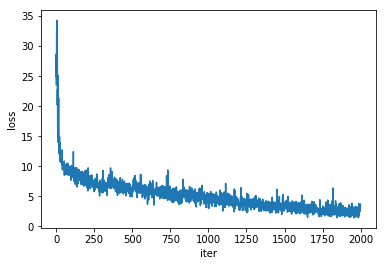

In [59]:
plt.plot(losses)
plt.xlabel("iter")
plt.ylabel("loss")
plt.show()

**Evaluate performance**

Evaluation...


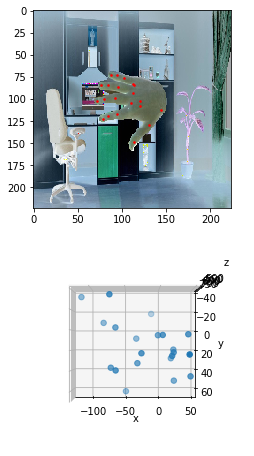

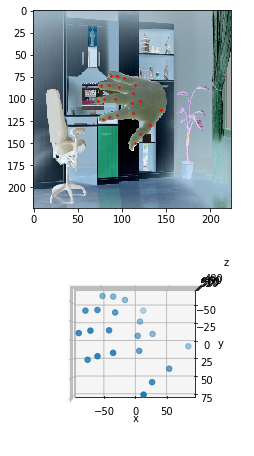

In [60]:
def makePosList(h_pred, l_pred):
    p2d_y, p2d_x = np.unravel_index(torch.argmax(h_pred.view(num_joints, -1), dim=1).data.numpy(), (image_size, image_size))
    p2d = np.stack((p2d_x, p2d_y), axis=-1)

    p3d_x = l_pred[0:21, :, :].data.numpy()
    p3d_x = p3d_x[np.arange(len(p3d_x)), p2d_y, p2d_x]

    p3d_y = l_pred[21:42, :, :].data.numpy()
    p3d_y = p3d_y[np.arange(len(p3d_y)), p2d_y, p2d_x]

    p3d_z = l_pred[42:63, :, :].data.numpy()
    p3d_z = p3d_z[np.arange(len(p3d_z)), p2d_y, p2d_x]

    p3d = np.stack((p3d_x, p3d_y, p3d_z), axis=-1)
    
    return p2d, p3d

print("Evaluation...")
eval_loss = 0
eval_iter = 0
for idx, batch in enumerate(loader_train):
    eval_iter = idx
    image = batch['image'].float()
    pos2d_list = batch['pos_2d'] # size (N, 21, 2)
    pos3d_list = batch['pos_3d'] # size (N, 21, 3)
    loc_map, heatmap, one_hot = makeMaps(pos2d_list, pos3d_list, batch_size, num_joints, image_size)
    y_pred = model(image)
    h_pred = modelHeatmap(y_pred)
    l_pred = modelLocmap(y_pred)
    #print("output shape: {}".format(y_pred.shape))
    # use heatmap loss defined in VNect
    #loss = computeLoss(heatmap, one_hot, loc_map, h_pred, l_pred, batch_size, num_joints, image_size)
    
    #eval_loss = eval_loss + loss
    
    if idx == 0:
        # show some images
        p2d, p3d = makePosList(h_pred[0], l_pred[0])
        show_joints(image[0].data.numpy().transpose((1,2,0)), p2d, p3d)
        show_joints(image[0].data.numpy().transpose((1,2,0)), batch['pos_2d'][0], batch['pos_3d'][0])
        break

#eval_iter = eval_iter + 1
#print("Eval Loss: {}".format(eval_loss / eval_iter))

**Save and load trained models**

In [245]:
#torch.save(model, 'model.pt')
#model = torch.load('model.pt')

# save/load only the model parameters(prefered solution)
torch.save(model.state_dict(), 'model_param.pt')
#model.load_state_dict(torch.load('model_param.pt'))